In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import date 
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
pd.options.display.max_columns = 600

df=pd.read_csv('airbnb_data_cleaned.csv')

In [3]:
df.head()

,neighborhood_overview,transit,access,interaction,house_rules,host_id,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,name_describe_host
0,0,1,1,1,1,2758,2008-09-06,In NY,within a few hours,0.70,1,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",1,1,Harlem,Manhattan,10026.0,40.799205,-73.953676,1,Apartment,Private room,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",59.0,0.0,60.0,2,39.0,2,21,today,3,12,23,298,175,93.0,9.0,9.0,10.0,9.0,9.0,9.0,0,strict_14_with_grace_period,0,0,1.42,Stay at Chez Chic budget room #1 Step into our...
1,1,1,1,1,1,42032,2009-09-29,In NY,within a day,0.80,0,1.0,"['email', 'phone', 'reviews', 'kba']",1,1,Upper West Side,Manhattan,10025.0,40.797642,-73.961775,1,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",140.0,0.0,40.0,2,28.0,5,365,yesterday,8,8,13,248,76,94.0,10.0,9.0,10.0,10.0,10.0,10.0,0,moderate,1,1,0.72,Light-filled classic Central Park An adorable...
2,1,1,0,0,1,2787,2008-09-07,In NY,within an hour,1.00,1,8.0,"['email', 'phone', 'reviews', 'kba']",1,1,Kensington,Brooklyn,11218.0,40.647486,-73.972370,0,Apartment,Private room,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",149.0,100.0,25.0,1,25.0,1,730,today,30,60,90,365,9,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,0,0,0.25,Clean & quiet apt home by the park Renovated a...
3,1,1,1,1,1,2845,2008-09-09,In NY,within a few hours,0.82,0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",1,1,Midtown,Manhattan,10018.0,40.753621,-73.983774,0,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",225.0,350.0,100.0,2,0.0,1,1125,3 days ago,15,45,75,350,41,95.0,9.0,9.0,10.0,10.0,10.0,9.0,0,strict_14_with_grace_period,1,1,0.37,Skylit Midtown Castle Find your romantic getaw...
4,1,1,1,1,1,82685,2010-02-18,In NY,did not respond,0.00,0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",1,1,Harlem,Manhattan,10031.0,40.828028,-73.947308,1,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",89.0,100.0,30.0,1,55.0,1,60,29 months ago,30,60,90,365,1,100.0,10.0,10.0,10.0,10.0,10.0,8.0,0,strict_14_with_grace_period,0,0,0.51,"Upper Manhattan, New York A great space in a b..."


ml_df is the dataframe with all the features that have been engineered. While df is the original dataframe. We will use ml_df for the eventural ml algorithms.

In [4]:
# Adding the first 5 columns with 0/1 features indicating whether the information was not provided/provided
ml_df = df[['neighborhood_overview','transit','access','interaction','house_rules']]

host ID - separate into bins (0-50 , 50-100, >100)

In [5]:
host_id = df[['host_id']]
host_id['count']=host_id.groupby(['host_id'])['host_id'].transform('count')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
def lists_binning(count):
    if count >100:
        return 'greater than 100'
    elif count <50:
        return 'less than 50'
    else:
        return '>50 and <100'

In [7]:
host_id['list_bins']=host_id['count'].apply(lists_binning)

listing_onehot_features = pd.get_dummies(host_id['list_bins'])
ml_df=pd.concat([ml_df, listing_onehot_features], axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We will use the year-month format to create a column and get dummies for that and include in ml_df. we will ignore the day.

In [8]:
host_since=pd.to_datetime(df['host_since'], format='%Y-%m-%d')
host_since=host_since.to_frame()
host_since['host_since_ym']=host_since['host_since'].apply(lambda x: (str(x.year)+'-'+str(x.month)))

ym_onehot_features = pd.get_dummies(host_since['host_since_ym'])

ml_df=pd.concat([ml_df, ym_onehot_features], axis=1)

Host location - encode for categorical
Host response time - encode for categorical

In [9]:
location_onehot_features = pd.get_dummies(df['host_location'])
ml_df=pd.concat([ml_df, location_onehot_features], axis=1)

responsetime_onehot_features = pd.get_dummies(df['host_response_time'])
ml_df=pd.concat([ml_df, responsetime_onehot_features], axis=1)

We will scale the host response rate on a scale of 100 and include that column in ml_df

In [10]:
response=df[['host_response_rate']]
response['host_response_rate_100'] = np.array(np.round((response['host_response_rate'] * 100)), dtype='int')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


adding the host response rate scales to 100 and the other two columns with numerical values.

In [11]:
ml_df = pd.concat([ml_df, response.host_response_rate_100, df.host_is_superhost,df.host_total_listings_count], axis=1)

host verifications - # of verifications
count of verifications included in ml_df

In [12]:
verifications=df[['host_verifications']]
verifications['verification_count'] = verifications.host_verifications.map(lambda x: [i.strip() for i in x.split(",")])
verifications['verification_count'] = verifications.verification_count.apply(len)

ml_df = pd.concat([ml_df, verifications.verification_count], axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
ml_df= pd.concat([ml_df, df.host_has_profile_pic, df.host_identity_verified], axis=1)

neighborhood cleansed - encode for categorical
neighborhood group cleansed - encode for categorical

In [14]:
nc_onehot_features = pd.get_dummies(df['neighbourhood_cleansed'])

ngc_onehot_features = pd.get_dummies(df['neighbourhood_group_cleansed'])

ml_df=pd.concat([ml_df, nc_onehot_features ,ngc_onehot_features], axis=1)

In [15]:
ml_df= pd.concat([ml_df, df.zipcode, df.latitude, df.longitude, df.is_location_exact], axis=1)

property type - encode for categorical
room type- encode for categorical
bed type - encode for categorical

In [16]:
pt_onehot_features = pd.get_dummies(df['property_type'])

rt_onehot_features = pd.get_dummies(df['room_type'])

ml_df = pd.concat([ml_df, pt_onehot_features ,rt_onehot_features], axis=1)

In [17]:
ml_df=pd.concat([ml_df,df.accommodates,df.bathrooms,df.bedrooms,df.beds],axis=1)

bed type - one hot encoding

In [18]:
bedt_onehot_features = pd.get_dummies(df['bed_type'])

ml_df = pd.concat([ml_df, bedt_onehot_features], axis=1)

amenities- # of amenitite

In [19]:
amenities=df[['amenities']]
amenities['amenity_count'] = amenities.amenities.map(lambda x: [i.strip() for i in x.split(",")])
amenities['amenity_count'] = amenities.amenity_count.apply(len)

ml_df = pd.concat([ml_df, amenities.amenity_count], axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
ml_df= pd.concat([ml_df, df.security_deposit, df.cleaning_fee, df.guests_included, df.extra_people,
                 df.minimum_nights, df.maximum_nights],axis=1)

calender updated - encode for categorical
cancellation policy - encode for categorical

In [21]:
calendar_onehot_features = pd.get_dummies(df['calendar_updated'])

ml_df = pd.concat([ml_df, calendar_onehot_features], axis=1)

In [22]:
ml_df = pd.concat([ml_df, df.availability_30, df.availability_60, df.availability_90, df.availability_365,
                  df.number_of_reviews, df.review_scores_rating], axis=1)

all review scores scaled to 100 instead of 10 and added to ml_df

In [23]:
reviews = df[['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location', 'review_scores_value']]  
def multiply_10(x):
    return x*10
reviews = reviews.apply(multiply_10)

In [24]:
ml_df = pd.concat([ml_df, reviews, df.instant_bookable],axis=1)

In [25]:
cancel_onehot_features = pd.get_dummies(df['cancellation_policy'])

ml_df = pd.concat([ml_df, cancel_onehot_features], axis=1)

In [26]:
ml_df=pd.concat([ml_df, df.require_guest_profile_picture, df.require_guest_phone_verification], axis=1)

scale reviews per month to 100

In [27]:
df.reviews_per_month.describe()

count    48353.000000
mean         1.140344
std          1.605117
min          0.000000
25%          0.050000
50%          0.410000
75%          1.670000
max         20.330000
Name: reviews_per_month, dtype: float64

In [28]:
rpm=df[['reviews_per_month']]
max_rpm = float(max(rpm.values))

In [29]:
def scale_to_100(x):
    scaled= x/max_rpm *100
    scaled = round(scaled, 2)
    return scaled

In [30]:
rpm = rpm.apply(scale_to_100)

ml_df = pd.concat([ml_df, rpm],axis=1)

In [31]:
price = df[['price']]
ml_df = pd.concat([ml_df, price],axis=1)

In [32]:
ml_df.head()

,neighborhood_overview,transit,access,interaction,house_rules,>50 and <100,greater than 100,less than 50,2008-10,2008-11,2008-12,2008-8,2008-9,2009-1,2009-10,2009-11,2009-12,2009-2,2009-3,2009-4,2009-5,2009-6,2009-7,2009-8,2009-9,2010-1,2010-10,2010-11,2010-12,2010-2,2010-3,2010-4,2010-5,2010-6,2010-7,2010-8,2010-9,2011-1,2011-10,2011-11,2011-12,2011-2,2011-3,2011-4,2011-5,2011-6,2011-7,2011-8,2011-9,2012-1,2012-10,2012-11,2012-12,2012-2,2012-3,2012-4,2012-5,2012-6,2012-7,2012-8,2012-9,2013-1,2013-10,2013-11,2013-12,2013-2,2013-3,2013-4,2013-5,2013-6,2013-7,2013-8,2013-9,2014-1,2014-10,2014-11,2014-12,2014-2,2014-3,2014-4,2014-5,2014-6,2014-7,2014-8,2014-9,2015-1,2015-10,2015-11,2015-12,2015-2,2015-3,2015-4,2015-5,2015-6,2015-7,2015-8,2015-9,2016-1,2016-10,2016-11,2016-12,2016-2,2016-3,2016-4,2016-5,2016-6,2016-7,2016-8,2016-9,2017-1,2017-10,2017-11,2017-12,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,2017-9,2018-1,2018-10,2018-11,2018-12,2018-2,2018-3,2018-4,2018-5,2018-6,2018-7,2018-8,2018-9,In NY,In US but not in NY,Not Provided,Not in US,a few days or more,did not respond,within a day,within a few hours,within an hour,host_response_rate_100,host_is_superhost,host_total_listings_count,verification_count,host_has_profile_pic,host_identity_verified,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",Baychester,Bayside,Bayswater,Bedford-Stuyvesant,Belle Harbor,Bellerose,Belmont,Bensonhurst,Bergen Beach,Boerum Hill,Borough Park,Breezy Point,Briarwood,Brighton Beach,Bronxdale,Brooklyn Heights,Brownsville,Bull's Head,Bushwick,Cambria Heights,Canarsie,Carroll Gardens,Castle Hill,Castleton Corners,Chelsea,Chinatown,City Island,Civic Center,Claremont Village,Clason Point,Clifton,Clinton Hill,Co-op City,Cobble Hill,College Point,Columbia St,Concord,Concourse,Concourse Village,Coney Island,Corona,Crown Heights,Cypress Hills,DUMBO,Ditmars Steinway,Dongan Hills,Douglaston,Downtown Brooklyn,Dyker Heights,East Elmhurst,East Flatbush,East Harlem,East Morrisania,East New York,East Village,Eastchester,Edenwald,Edgemere,Elmhurst,Eltingville,Emerson Hill,Far Rockaway,Fieldston,Financial District,Flatbush,Flatiron District,Flatlands,Flushing,Fordham,Forest Hills,Fort Greene,Fort Hamilton,Fort Wadsworth,Fresh Meadows,Gerritsen Beach,Glendale,Gowanus,Gramercy,Graniteville,Grant City,Gravesend,Great Kills,Greenpoint,Greenwich Village,Grymes Hill,Harlem,Hell's Kitchen,Highbridge,Hollis,Holliswood,Howard Beach,Howland Hook,Huguenot,Hunts Point,Inwood,Jackson Heights,Jamaica,Jamaica Estates,Jamaica Hills,Kensington,Kew Gardens,Kew Gardens Hills,Kingsbridge,Kips Bay,Laurelton,Lighthouse Hill,Little Italy,Little Neck,Long Island City,Longwood,Lower East Side,Manhattan Beach,Marble Hill,Mariners Harbor,Maspeth,Melrose,Middle Village,Midland Beach,Midtown,Midwood,Mill Basin,Morningside Heights,Morris Heights,Morris Park,Morrisania,Mott Haven,Mount Eden,Mount Hope,Murray Hill,Navy Yard,Neponsit,New Brighton,New Dorp,New Dorp Beach,New Springville,NoHo,Nolita,North Riverdale,Norwood,Oakwood,Olinville,Ozone Park,Park Slope,Parkchester,Pelham Bay,Pelham Gardens,Pleasant Plains,Port Morris,Port Richmond,Prince's Bay,Prospect Heights,Prospect-Lefferts Gardens,Queens Village,Randall Manor,Red Hook,Rego Park,Richmond Hill,Richmondtown,Ridgewood,Riverdale,Rockaway Beach,Roosevelt Island,Rosebank,Rosedale,Rossville,Schuylerville,Sea Gate,Sheepshead Bay,Shore Acres,Silver Lake,SoHo,Soundview,South Beach,South Ozone Park,South Slope,Springfield Gardens,Spuyten Duyvil,St. Albans,St. George,Stapleton,Stuyvesant Town,Sunnyside,Sunset Park,Theater District,Throgs Neck,Todt Hill,Tompkinsville,Tottenville,Tremont,Tribeca,Two Bridges,Unionport,University Heights,Upper East Side,Upper West Side,Van Nest,Vinegar Hill,Wakefield,Washington Heights,West Brighton,West Farms,West Village,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Wo

In [33]:
ml_df.shape

(48353, 536)

* saving the dataframe with feature engineering.

In [34]:
ml_df.to_csv('ML_df_all_features.csv',index=False) 

Dataframe with less columns (no dates, neighbourhood, property type, calender updated

In [35]:
ml_df_less = pd.concat([df.neighborhood_overview, df.transit, df.access, df.interaction, df.house_rules,
                       listing_onehot_features, location_onehot_features,responsetime_onehot_features,
                       response.host_response_rate_100, df.host_is_superhost,df.host_total_listings_count,
                       verifications.verification_count, df.host_has_profile_pic, df.host_identity_verified,
                       ngc_onehot_features,df.zipcode, df.latitude, df.longitude, df.is_location_exact,
                       rt_onehot_features,df.accommodates,df.bathrooms,df.bedrooms,df.beds,bedt_onehot_features,
                       amenities.amenity_count, df.security_deposit, df.cleaning_fee, df.guests_included, 
                       df.extra_people, df.minimum_nights, df.maximum_nights, df.availability_30, df.availability_60, 
                       df.availability_90, df.availability_365, df.number_of_reviews, df.review_scores_rating, 
                       reviews, df.instant_bookable, df.require_guest_profile_picture, 
                       df.require_guest_phone_verification, rpm, price], axis=1)

In [36]:
ml_df_less.shape

(48353, 68)

******

In [37]:
ml_df=pd.read_csv('ML_df_all_features.csv')

In [38]:
ml_df.head()

,neighborhood_overview,transit,access,interaction,house_rules,>50 and <100,greater than 100,less than 50,2008-10,2008-11,2008-12,2008-8,2008-9,2009-1,2009-10,2009-11,2009-12,2009-2,2009-3,2009-4,2009-5,2009-6,2009-7,2009-8,2009-9,2010-1,2010-10,2010-11,2010-12,2010-2,2010-3,2010-4,2010-5,2010-6,2010-7,2010-8,2010-9,2011-1,2011-10,2011-11,2011-12,2011-2,2011-3,2011-4,2011-5,2011-6,2011-7,2011-8,2011-9,2012-1,2012-10,2012-11,2012-12,2012-2,2012-3,2012-4,2012-5,2012-6,2012-7,2012-8,2012-9,2013-1,2013-10,2013-11,2013-12,2013-2,2013-3,2013-4,2013-5,2013-6,2013-7,2013-8,2013-9,2014-1,2014-10,2014-11,2014-12,2014-2,2014-3,2014-4,2014-5,2014-6,2014-7,2014-8,2014-9,2015-1,2015-10,2015-11,2015-12,2015-2,2015-3,2015-4,2015-5,2015-6,2015-7,2015-8,2015-9,2016-1,2016-10,2016-11,2016-12,2016-2,2016-3,2016-4,2016-5,2016-6,2016-7,2016-8,2016-9,2017-1,2017-10,2017-11,2017-12,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,2017-9,2018-1,2018-10,2018-11,2018-12,2018-2,2018-3,2018-4,2018-5,2018-6,2018-7,2018-8,2018-9,In NY,In US but not in NY,Not Provided,Not in US,a few days or more,did not respond,within a day,within a few hours,within an hour,host_response_rate_100,host_is_superhost,host_total_listings_count,verification_count,host_has_profile_pic,host_identity_verified,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",Baychester,Bayside,Bayswater,Bedford-Stuyvesant,Belle Harbor,Bellerose,Belmont,Bensonhurst,Bergen Beach,Boerum Hill,Borough Park,Breezy Point,Briarwood,Brighton Beach,Bronxdale,Brooklyn Heights,Brownsville,Bull's Head,Bushwick,Cambria Heights,Canarsie,Carroll Gardens,Castle Hill,Castleton Corners,Chelsea,Chinatown,City Island,Civic Center,Claremont Village,Clason Point,Clifton,Clinton Hill,Co-op City,Cobble Hill,College Point,Columbia St,Concord,Concourse,Concourse Village,Coney Island,Corona,Crown Heights,Cypress Hills,DUMBO,Ditmars Steinway,Dongan Hills,Douglaston,Downtown Brooklyn,Dyker Heights,East Elmhurst,East Flatbush,East Harlem,East Morrisania,East New York,East Village,Eastchester,Edenwald,Edgemere,Elmhurst,Eltingville,Emerson Hill,Far Rockaway,Fieldston,Financial District,Flatbush,Flatiron District,Flatlands,Flushing,Fordham,Forest Hills,Fort Greene,Fort Hamilton,Fort Wadsworth,Fresh Meadows,Gerritsen Beach,Glendale,Gowanus,Gramercy,Graniteville,Grant City,Gravesend,Great Kills,Greenpoint,Greenwich Village,Grymes Hill,Harlem,Hell's Kitchen,Highbridge,Hollis,Holliswood,Howard Beach,Howland Hook,Huguenot,Hunts Point,Inwood,Jackson Heights,Jamaica,Jamaica Estates,Jamaica Hills,Kensington,Kew Gardens,Kew Gardens Hills,Kingsbridge,Kips Bay,Laurelton,Lighthouse Hill,Little Italy,Little Neck,Long Island City,Longwood,Lower East Side,Manhattan Beach,Marble Hill,Mariners Harbor,Maspeth,Melrose,Middle Village,Midland Beach,Midtown,Midwood,Mill Basin,Morningside Heights,Morris Heights,Morris Park,Morrisania,Mott Haven,Mount Eden,Mount Hope,Murray Hill,Navy Yard,Neponsit,New Brighton,New Dorp,New Dorp Beach,New Springville,NoHo,Nolita,North Riverdale,Norwood,Oakwood,Olinville,Ozone Park,Park Slope,Parkchester,Pelham Bay,Pelham Gardens,Pleasant Plains,Port Morris,Port Richmond,Prince's Bay,Prospect Heights,Prospect-Lefferts Gardens,Queens Village,Randall Manor,Red Hook,Rego Park,Richmond Hill,Richmondtown,Ridgewood,Riverdale,Rockaway Beach,Roosevelt Island,Rosebank,Rosedale,Rossville,Schuylerville,Sea Gate,Sheepshead Bay,Shore Acres,Silver Lake,SoHo,Soundview,South Beach,South Ozone Park,South Slope,Springfield Gardens,Spuyten Duyvil,St. Albans,St. George,Stapleton,Stuyvesant Town,Sunnyside,Sunset Park,Theater District,Throgs Neck,Todt Hill,Tompkinsville,Tottenville,Tremont,Tribeca,Two Bridges,Unionport,University Heights,Upper East Side,Upper West Side,Van Nest,Vinegar Hill,Wakefield,Washington Heights,West Brighton,West Farms,West Village,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Wo

removing price outliers

In [39]:
q = ml_df["price"].quantile(0.90)

ml_df_o = ml_df[ml_df["price"] < q]

In [40]:
ml_df_o.shape

(43514, 536)

Scale numeric columns using standardscaler

In [41]:
ml_df_scaled = ml_df_o.copy(deep=True)

In [42]:
scale_cols = ['host_response_rate_100', 'host_total_listings_count', 'verification_count', 'zipcode', 'latitude', 'longitude',
'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenity_count', 'security_deposit', 'cleaning_fee', 'guests_included',
'extra_people','minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90',
'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
'reviews_per_month', 'price']

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ml_df_scaled[scale_cols] = scaler.fit_transform(ml_df_scaled[scale_cols])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [44]:
ml_df_scaled.head()

,neighborhood_overview,transit,access,interaction,house_rules,>50 and <100,greater than 100,less than 50,2008-10,2008-11,2008-12,2008-8,2008-9,2009-1,2009-10,2009-11,2009-12,2009-2,2009-3,2009-4,2009-5,2009-6,2009-7,2009-8,2009-9,2010-1,2010-10,2010-11,2010-12,2010-2,2010-3,2010-4,2010-5,2010-6,2010-7,2010-8,2010-9,2011-1,2011-10,2011-11,2011-12,2011-2,2011-3,2011-4,2011-5,2011-6,2011-7,2011-8,2011-9,2012-1,2012-10,2012-11,2012-12,2012-2,2012-3,2012-4,2012-5,2012-6,2012-7,2012-8,2012-9,2013-1,2013-10,2013-11,2013-12,2013-2,2013-3,2013-4,2013-5,2013-6,2013-7,2013-8,2013-9,2014-1,2014-10,2014-11,2014-12,2014-2,2014-3,2014-4,2014-5,2014-6,2014-7,2014-8,2014-9,2015-1,2015-10,2015-11,2015-12,2015-2,2015-3,2015-4,2015-5,2015-6,2015-7,2015-8,2015-9,2016-1,2016-10,2016-11,2016-12,2016-2,2016-3,2016-4,2016-5,2016-6,2016-7,2016-8,2016-9,2017-1,2017-10,2017-11,2017-12,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,2017-9,2018-1,2018-10,2018-11,2018-12,2018-2,2018-3,2018-4,2018-5,2018-6,2018-7,2018-8,2018-9,In NY,In US but not in NY,Not Provided,Not in US,a few days or more,did not respond,within a day,within a few hours,within an hour,host_response_rate_100,host_is_superhost,host_total_listings_count,verification_count,host_has_profile_pic,host_identity_verified,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",Baychester,Bayside,Bayswater,Bedford-Stuyvesant,Belle Harbor,Bellerose,Belmont,Bensonhurst,Bergen Beach,Boerum Hill,Borough Park,Breezy Point,Briarwood,Brighton Beach,Bronxdale,Brooklyn Heights,Brownsville,Bull's Head,Bushwick,Cambria Heights,Canarsie,Carroll Gardens,Castle Hill,Castleton Corners,Chelsea,Chinatown,City Island,Civic Center,Claremont Village,Clason Point,Clifton,Clinton Hill,Co-op City,Cobble Hill,College Point,Columbia St,Concord,Concourse,Concourse Village,Coney Island,Corona,Crown Heights,Cypress Hills,DUMBO,Ditmars Steinway,Dongan Hills,Douglaston,Downtown Brooklyn,Dyker Heights,East Elmhurst,East Flatbush,East Harlem,East Morrisania,East New York,East Village,Eastchester,Edenwald,Edgemere,Elmhurst,Eltingville,Emerson Hill,Far Rockaway,Fieldston,Financial District,Flatbush,Flatiron District,Flatlands,Flushing,Fordham,Forest Hills,Fort Greene,Fort Hamilton,Fort Wadsworth,Fresh Meadows,Gerritsen Beach,Glendale,Gowanus,Gramercy,Graniteville,Grant City,Gravesend,Great Kills,Greenpoint,Greenwich Village,Grymes Hill,Harlem,Hell's Kitchen,Highbridge,Hollis,Holliswood,Howard Beach,Howland Hook,Huguenot,Hunts Point,Inwood,Jackson Heights,Jamaica,Jamaica Estates,Jamaica Hills,Kensington,Kew Gardens,Kew Gardens Hills,Kingsbridge,Kips Bay,Laurelton,Lighthouse Hill,Little Italy,Little Neck,Long Island City,Longwood,Lower East Side,Manhattan Beach,Marble Hill,Mariners Harbor,Maspeth,Melrose,Middle Village,Midland Beach,Midtown,Midwood,Mill Basin,Morningside Heights,Morris Heights,Morris Park,Morrisania,Mott Haven,Mount Eden,Mount Hope,Murray Hill,Navy Yard,Neponsit,New Brighton,New Dorp,New Dorp Beach,New Springville,NoHo,Nolita,North Riverdale,Norwood,Oakwood,Olinville,Ozone Park,Park Slope,Parkchester,Pelham Bay,Pelham Gardens,Pleasant Plains,Port Morris,Port Richmond,Prince's Bay,Prospect Heights,Prospect-Lefferts Gardens,Queens Village,Randall Manor,Red Hook,Rego Park,Richmond Hill,Richmondtown,Ridgewood,Riverdale,Rockaway Beach,Roosevelt Island,Rosebank,Rosedale,Rossville,Schuylerville,Sea Gate,Sheepshead Bay,Shore Acres,Silver Lake,SoHo,Soundview,South Beach,South Ozone Park,South Slope,Springfield Gardens,Spuyten Duyvil,St. Albans,St. George,Stapleton,Stuyvesant Town,Sunnyside,Sunset Park,Theater District,Throgs Neck,Todt Hill,Tompkinsville,Tottenville,Tremont,Tribeca,Two Bridges,Unionport,University Heights,Upper East Side,Upper West Side,Van Nest,Vinegar Hill,Wakefield,Washington Heights,West Brighton,West Farms,West Village,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Wo

**Linear Regression on scaled dataframe**

In [45]:
ml_df_scaled_noprice = ml_df_scaled.drop('price', axis=1)

In [46]:
from sklearn.model_selection import train_test_split

X = ml_df_scaled_noprice
y = ml_df_scaled.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [47]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [48]:
coefficients = pd.DataFrame({'features': X_train.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]
coefficients.head()

,features,estimatedCoefficients
0,neighborhood_overview,0.009921
1,transit,-0.019169
2,access,-0.009772
3,interaction,-0.008661
4,house_rules,-0.007548


In [49]:
print('training_score = ', lm.score(X_train, y_train))
print('testing_score = ', lm.score(X_test, y_test))

training_score =  0.6494265372206705
testing_score =  -2.3717025901071756e+16


Text(0.5,0,'Actual Prices')

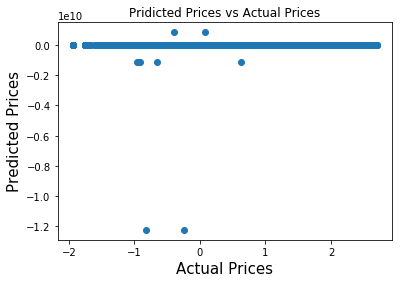

In [50]:
plt.scatter(y_test, lm.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

**linear regression on non-scaled dataframe**

In [51]:
model_scores = {}

In [52]:
ml_df_o_noprice = ml_df_o.drop('price', axis=1)

In [53]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [54]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [55]:
print('training_score = ', lm.score(X_train, y_train))
print('testing_score = ', lm.score(X_test, y_test))

model_scores['linear_regression']={'train':lm.score(X_train, y_train), 'test':lm.score(X_test, y_test)}

training_score =  0.6494271315730508
testing_score =  0.6418396228055516


In [56]:
coefficients = pd.DataFrame({'features': X_train.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]
#coefficients

Text(0.5,0,'Actual Prices')

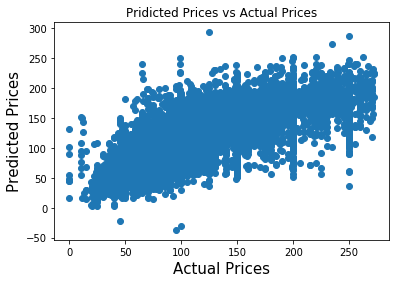

In [57]:
plt.scatter(y_test, lm.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

******

**Decision Tree**

In [58]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [59]:
from sklearn import tree
decision_tree = tree.DecisionTreeRegressor(max_features='sqrt', min_impurity_decrease=0.5)
tree_model = decision_tree.fit(X_train, y_train)

In [60]:
print('training score = ', tree_model.score(X_train,y_train))
print('testing score = ', tree_model.score(X_test,y_test))

model_scores['decision_tree']={'train':tree_model.score(X_train, y_train), 'test':tree_model.score(X_test, y_test)}

training score =  0.4900479252056398
testing score =  0.47250153044579685


Text(0.5,0,'Actual Prices')

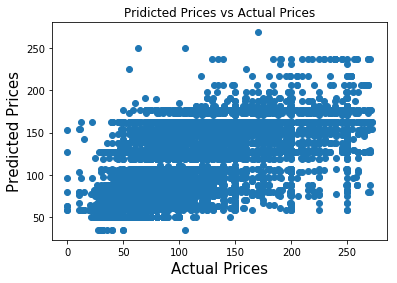

In [61]:
plt.scatter(y_test, tree_model.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

****

**Random Forest**

In [62]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [63]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=50, max_features='sqrt')
rf_model = random_forest.fit(X_train, y_train)

In [64]:
print('training score = ', rf_model.score(X_train,y_train))
print('testing score = ', rf_model.score(X_test,y_test))

model_scores['random_forest']={'train':rf_model.score(X_train, y_train), 'test':rf_model.score(X_test, y_test)}

training score =  0.9507894690370489
testing score =  0.6681713521021024


Text(0.5,0,'Actual Prices')

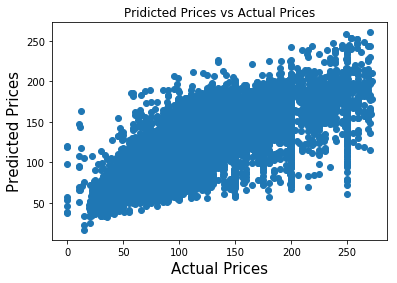

In [65]:
plt.scatter(y_test, rf_model.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

*****

**Gradient Boosting**

In [66]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [67]:
from sklearn.ensemble import GradientBoostingRegressor
gradient_boost = GradientBoostingRegressor()
gb_model = gradient_boost.fit(X_train, y_train)

In [68]:
print('training score = ', gb_model.score(X_train, y_train))
print('testing score = ', gb_model.score(X_test, y_test))

model_scores['gradient_boost']={'train':gb_model.score(X_train, y_train), 'test':gb_model.score(X_test, y_test)}

training score =  0.6799078804090641
testing score =  0.6754057502530524


Text(0.5,0,'Actual Prices')

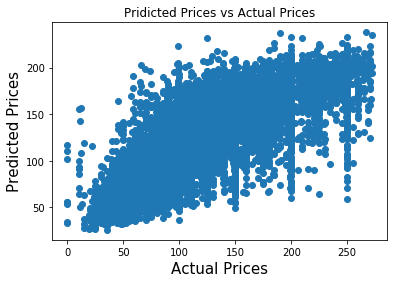

In [69]:
plt.scatter(y_test, gb_model.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

****

**Adaboost regression**

In [70]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [71]:
from sklearn.ensemble import AdaBoostRegressor
ada_boost = AdaBoostRegressor()
ada_model = ada_boost.fit(X_train, y_train)

In [72]:
print('training score = ', ada_model.score(X_train, y_train))
print('testing score = ', ada_model.score(X_test, y_test))

model_scores['adaboost']={'train':ada_model.score(X_train, y_train), 'test':ada_model.score(X_test, y_test)}

training score =  0.4198211973290702
testing score =  0.4034017090401811


Text(0.5,0,'Actual Prices')

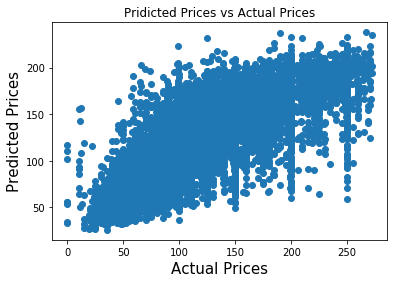

In [73]:
plt.scatter(y_test, gb_model.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

**KNN regression**

In [74]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [75]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn_model = knn.fit(X_train, y_train)

In [76]:
print('training score = ', knn_model.score(X_train, y_train))
print('testing score = ', knn_model.score(X_test, y_test))

model_scores['KNN']={'train':knn_model.score(X_train, y_train), 'test':knn_model.score(X_test, y_test)}

training score =  0.5202360140372473
testing score =  0.291430791412678


Text(0.5,0,'Actual Prices')

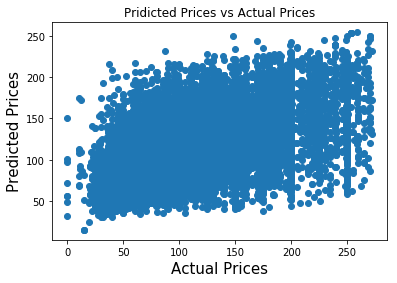

In [77]:
plt.scatter(y_test, knn_model.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

**XG Boost**

In [78]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

ml_df_o_noprice.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in ml_df_o_noprice.columns.values]

X = ml_df_o_noprice
y = ml_df_o.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [79]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:linear')
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [80]:
print('training score = ', xg_reg.score(X_train, y_train))
print('testing score = ', xg_reg.score(X_test, y_test))

model_scores['XGboost']={'train':xg_reg.score(X_train, y_train), 'test':xg_reg.score(X_test, y_test)}

training score =  0.6789886430547732
testing score =  0.6752471318648172


In [81]:
model_scores

{'linear_regression': {'train': 0.6494271315730508,
  'test': 0.6418396228055516},
 'decision_tree': {'train': 0.4900479252056398, 'test': 0.47250153044579685},
 'random_forest': {'train': 0.9507894690370489, 'test': 0.6681713521021024},
 'gradient_boost': {'train': 0.6799078804090641, 'test': 0.6754057502530524},
 'adaboost': {'train': 0.4198211973290702, 'test': 0.4034017090401811},
 'KNN': {'train': 0.5202360140372473, 'test': 0.291430791412678},
 'XGboost': {'train': 0.6789886430547732, 'test': 0.6752471318648172}}

In [82]:
models = pd.DataFrame(model_scores)
models = models.T
models

,test,train
linear_regression,0.641840,0.649427
decision_tree,0.472502,0.490048
random_forest,0.668171,0.950789
gradient_boost,0.675406,0.679908
adaboost,0.403402,0.419821
KNN,0.291431,0.520236
XGboost,0.675247,0.678989


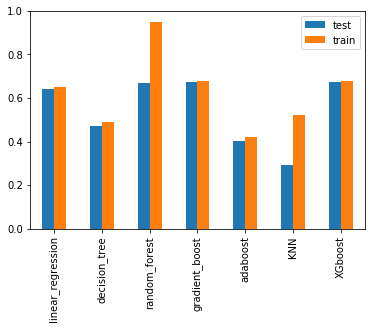

In [83]:
models.plot(kind='bar')

*********
********

## **ml_df_less - without neighborhood, host joined date, property type, calender updated - because those columns had many unique values - increased the number of features drastically**

In [84]:
model_scores_less={}

In [85]:
ml_df_less.shape

(48353, 68)

In [86]:
q = ml_df_less["price"].quantile(0.90)
ml_df_less_o = ml_df_less[ml_df_less["price"] < q]     #remove outlier price rows

In [87]:
ml_df_less_o_noprice = ml_df_less_o.drop('price', axis=1)

X = ml_df_less_o_noprice
y = ml_df_less_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [88]:
lm = LinearRegression()
lm.fit(X_train, y_train)

print('training_score = ', lm.score(X_train, y_train))
print('testing_score = ', lm.score(X_test, y_test))

model_scores_less['linear_regression']={'train':lm.score(X_train, y_train), 'test':lm.score(X_test, y_test)}

training_score =  0.5840872046125833
testing_score =  0.5825919003960262


In [89]:
decision_tree = tree.DecisionTreeRegressor(max_features='sqrt', min_impurity_decrease=0.5)
tree_model = decision_tree.fit(X_train, y_train)

print('training score = ', tree_model.score(X_train,y_train))
print('testing score = ', tree_model.score(X_test,y_test))

model_scores_less['decision_tree']={'train':tree_model.score(X_train, y_train), 'test':tree_model.score(X_test, y_test)}

training score =  0.6021924354315578
testing score =  0.5642717427805661


In [90]:
random_forest = RandomForestRegressor(n_estimators=50, max_features='sqrt')
rf_model = random_forest.fit(X_train, y_train)

print('training score = ', rf_model.score(X_train,y_train))
print('testing score = ', rf_model.score(X_test,y_test))

model_scores_less['random_forest']={'train':rf_model.score(X_train, y_train), 'test':rf_model.score(X_test, y_test)}

training score =  0.9526181990497918
testing score =  0.6812381477068739


In [91]:
gradient_boost = GradientBoostingRegressor()
gb_model = gradient_boost.fit(X_train, y_train)

print('training score = ', gb_model.score(X_train, y_train))
print('testing score = ', gb_model.score(X_test, y_test))

model_scores_less['gradient_boost']={'train':gb_model.score(X_train, y_train), 'test':gb_model.score(X_test, y_test)}

training score =  0.6787178278641819
testing score =  0.6746245809013114


In [92]:
ada_boost = AdaBoostRegressor()
ada_model = ada_boost.fit(X_train, y_train)

print('training score = ', ada_model.score(X_train, y_train))
print('testing score = ', ada_model.score(X_test, y_test))

model_scores_less['adaboost']={'train':ada_model.score(X_train, y_train), 'test':ada_model.score(X_test, y_test)}

training score =  0.2672628880005161
testing score =  0.24259132522965


In [93]:
knn = KNeighborsRegressor()
knn_model = knn.fit(X_train, y_train)

print('training score = ', knn_model.score(X_train, y_train))
print('testing score = ', knn_model.score(X_test, y_test))

model_scores_less['KNN']={'train':knn_model.score(X_train, y_train), 'test':knn_model.score(X_test, y_test)}

training score =  0.5203775649309927
testing score =  0.2909443136393072


In [94]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

ml_df_less_o_noprice.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in ml_df_less_o_noprice.columns.values]

X = ml_df_less_o_noprice
y = ml_df_less_o.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

xg_reg = xgb.XGBRegressor(objective ='reg:linear')
xg_reg.fit(X_train,y_train)

print('training score = ', xg_reg.score(X_train, y_train))
print('testing score = ', xg_reg.score(X_test, y_test))

model_scores_less['XGboost']={'train':xg_reg.score(X_train, y_train), 'test':xg_reg.score(X_test, y_test)}

training score =  0.6779763077765553
testing score =  0.6735826303243218


In [95]:
models_less = pd.DataFrame(model_scores_less)
models_less = models_less.T
models_less

,test,train
linear_regression,0.582592,0.584087
decision_tree,0.564272,0.602192
random_forest,0.681238,0.952618
gradient_boost,0.674625,0.678718
adaboost,0.242591,0.267263
KNN,0.290944,0.520378
XGboost,0.673583,0.677976


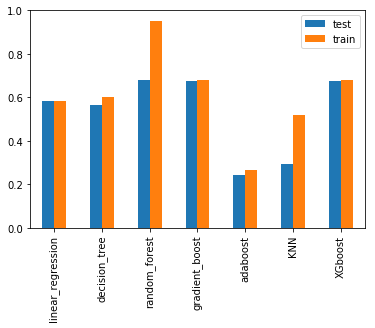

In [96]:
models_less.plot(kind='bar')

******
******
##  Removing features with low variance

In [97]:
model_scores_low_variance={}

In [98]:
from sklearn.feature_selection import VarianceThreshold

X = ml_df_o_noprice
y = ml_df_o.price

sel = VarianceThreshold(threshold=(0.5))
X_new = sel.fit_transform(X)
print(X_new.shape)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=6)

(43514, 26)


In [99]:
lm = LinearRegression()
lm.fit(X_train, y_train)

print('training_score = ', lm.score(X_train, y_train))
print('testing_score = ', lm.score(X_test, y_test))

model_scores_low_variance['linear_regression']={'train':lm.score(X_train, y_train), 'test':lm.score(X_test, y_test)}

training_score =  0.36976749218658134
testing_score =  0.3837267179948293


In [100]:
decision_tree = tree.DecisionTreeRegressor(max_features='sqrt', min_impurity_decrease=0.5)
tree_model = decision_tree.fit(X_train, y_train)

print('training score = ', tree_model.score(X_train,y_train))
print('testing score = ', tree_model.score(X_test,y_test))

model_scores_low_variance['decision_tree']={'train':tree_model.score(X_train, y_train), 'test':tree_model.score(X_test, y_test)}

training score =  0.5180804595933015
testing score =  0.47522137075651


In [101]:
random_forest = RandomForestRegressor(n_estimators=50, max_features='sqrt')
rf_model = random_forest.fit(X_train, y_train)

print('training score = ', rf_model.score(X_train,y_train))
print('testing score = ', rf_model.score(X_test,y_test))

model_scores_low_variance['random_forest']={'train':rf_model.score(X_train, y_train), 'test':rf_model.score(X_test, y_test)}

training score =  0.9390223942943957
testing score =  0.592005466431872


In [102]:
gradient_boost = GradientBoostingRegressor()
gb_model = gradient_boost.fit(X_train, y_train)

print('training score = ', gb_model.score(X_train, y_train))
print('testing score = ', gb_model.score(X_test, y_test))

model_scores_low_variance['gradient_boost']={'train':gb_model.score(X_train, y_train), 'test':gb_model.score(X_test, y_test)}

training score =  0.5891882896572279
testing score =  0.5873648091203434


In [103]:
ada_boost = AdaBoostRegressor()
ada_model = ada_boost.fit(X_train, y_train)

print('training score = ', ada_model.score(X_train, y_train))
print('testing score = ', ada_model.score(X_test, y_test))

model_scores_low_variance['adaboost']={'train':ada_model.score(X_train, y_train), 'test':ada_model.score(X_test, y_test)}

training score =  0.2414261941947191
testing score =  0.22551372811771653


In [104]:
knn = KNeighborsRegressor()
knn_model = knn.fit(X_train, y_train)

print('training score = ', knn_model.score(X_train, y_train))
print('testing score = ', knn_model.score(X_test, y_test))

model_scores_low_variance['KNN']={'train':knn_model.score(X_train, y_train), 'test':knn_model.score(X_test, y_test)}

training score =  0.5176208033927727
testing score =  0.28813436394029524


In [105]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')
xg_reg.fit(X_train,y_train)

print('training score = ', xg_reg.score(X_train, y_train))
print('testing score = ', xg_reg.score(X_test, y_test))

model_scores_low_variance['XGboost']={'train':xg_reg.score(X_train, y_train), 'test':xg_reg.score(X_test, y_test)}

training score =  0.591372180984854
testing score =  0.5911219859810835


In [106]:
models_low_variance = pd.DataFrame(model_scores_low_variance)
models_low_variance = models_low_variance.T
models_low_variance

,test,train
linear_regression,0.383727,0.369767
decision_tree,0.475221,0.518080
random_forest,0.592005,0.939022
gradient_boost,0.587365,0.589188
adaboost,0.225514,0.241426
KNN,0.288134,0.517621
XGboost,0.591122,0.591372


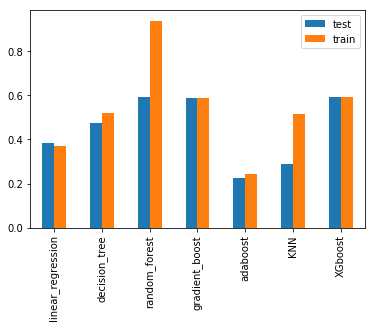

In [107]:
models_low_variance.plot(kind='bar')

******
******
##  Select from Model

In [108]:
model_scores_sfm={}

In [121]:
from sklearn.feature_selection import SelectFromModel

X = ml_df_o_noprice
y = ml_df_o.price

lm = LinearRegression()

sfm = SelectFromModel(lm, threshold='median', max_features=50)
X_new= sfm.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=6)

lm.fit(X_train, y_train)
print('training_score = ', lm.score(X_train, y_train))
print('testing_score = ', lm.score(X_test, y_test))

model_scores_sfm['linear_regression']={'train':lm.score(X_train, y_train), 'test':lm.score(X_test, y_test)}

training_score =  0.03133286112765565
testing_score =  0.028228782355797066


In [110]:
X, y = ml_df_o_noprice , ml_df_o.price

decision_tree = tree.DecisionTreeRegressor(max_features='sqrt', min_impurity_decrease=0.5)

sfm = SelectFromModel(decision_tree, threshold='median')
X_new= sfm.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=6)

decision_tree.fit(X_train, y_train)

print('training score = ', decision_tree.score(X_train,y_train))
print('testing score = ', decision_tree.score(X_test,y_test))

model_scores_sfm['decision_tree']={'train':decision_tree.score(X_train, y_train), 'test':decision_tree.score(X_test, y_test)}


training score =  0.4800636285462978
testing score =  0.46784536282169653


In [111]:
X, y = ml_df_o_noprice , ml_df_o.price

random_forest = RandomForestRegressor(n_estimators=50, max_features='sqrt')

sfm = SelectFromModel(random_forest, threshold='median')
X_new= sfm.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=6)

random_forest.fit(X_train, y_train)

print('training score = ', random_forest.score(X_train,y_train))
print('testing score = ', random_forest.score(X_test,y_test))

model_scores_sfm['random_forest']={'train':random_forest.score(X_train, y_train), 'test':random_forest.score(X_test, y_test)}


training score =  0.9517254699226585
testing score =  0.6748023201439433


In [112]:
X, y = ml_df_o_noprice , ml_df_o.price

gradient_boost = GradientBoostingRegressor()

sfm = SelectFromModel(gradient_boost, threshold='median')
X_new= sfm.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=6)
gradient_boost.fit(X_train, y_train)

print('training score = ', gradient_boost.score(X_train, y_train))
print('testing score = ', gradient_boost.score(X_test, y_test))

model_scores_sfm['gradient_boost']={'train':gradient_boost.score(X_train, y_train), 'test':gradient_boost.score(X_test, y_test)}


training score =  0.6799078804090641
testing score =  0.675433217384361


In [113]:
X, y = ml_df_o_noprice , ml_df_o.price

ada_boost = AdaBoostRegressor()

sfm = SelectFromModel(ada_boost, threshold='median')
X_new= sfm.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=6)
ada_boost.fit(X_train, y_train)

print('training score = ', ada_boost.score(X_train, y_train))
print('testing score = ', ada_boost.score(X_test, y_test))

model_scores_sfm['adaboost']={'train':ada_boost.score(X_train, y_train), 'test':ada_boost.score(X_test, y_test)}

training score =  0.4905654079028441
testing score =  0.48117871105277943


In [114]:
#X, y = ml_df_o_noprice , ml_df_o.price

#knn = KNeighborsRegressor()
#knn.fit(X,y)

#sfm = SelectFromModel(knn, prefit=True, threshold='median')
#X_new= sfm.transform(X)

#X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=6)
#knn.fit(X_train, y_train)

#print('training score = ', knn.score(X_train, y_train))
#print('testing score = ', knn.score(X_test, y_test))

#model_scores_sfm['KNN']={'train':knn.score(X_train, y_train), 'test':knn.score(X_test, y_test)}
model_scores_sfm['KNN']={'train':0, 'test':0}

In [115]:
X, y = ml_df_o_noprice , ml_df_o.price

xg_reg = xgb.XGBRegressor(objective ='reg:linear')

sfm = SelectFromModel(xg_reg, threshold='median')
X_new= sfm.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=6)

xg_reg.fit(X_train,y_train)

print('training score = ', xg_reg.score(X_train, y_train))
print('testing score = ', xg_reg.score(X_test, y_test))

model_scores_sfm['XGboost']={'train':xg_reg.score(X_train, y_train), 'test':xg_reg.score(X_test, y_test)}

training score =  0.6789886430547732
testing score =  0.6752471318648172


In [122]:
models_sfm = pd.DataFrame(model_scores_sfm)
models_sfm = models_sfm.T
models_sfm

,test,train
linear_regression,0.028229,0.031333
decision_tree,0.467845,0.480064
random_forest,0.674802,0.951725
gradient_boost,0.675433,0.679908
adaboost,0.481179,0.490565
KNN,0.000000,0.000000
XGboost,0.675247,0.678989


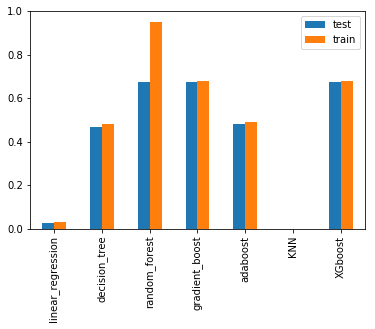

In [123]:
models_sfm.plot(kind='bar')

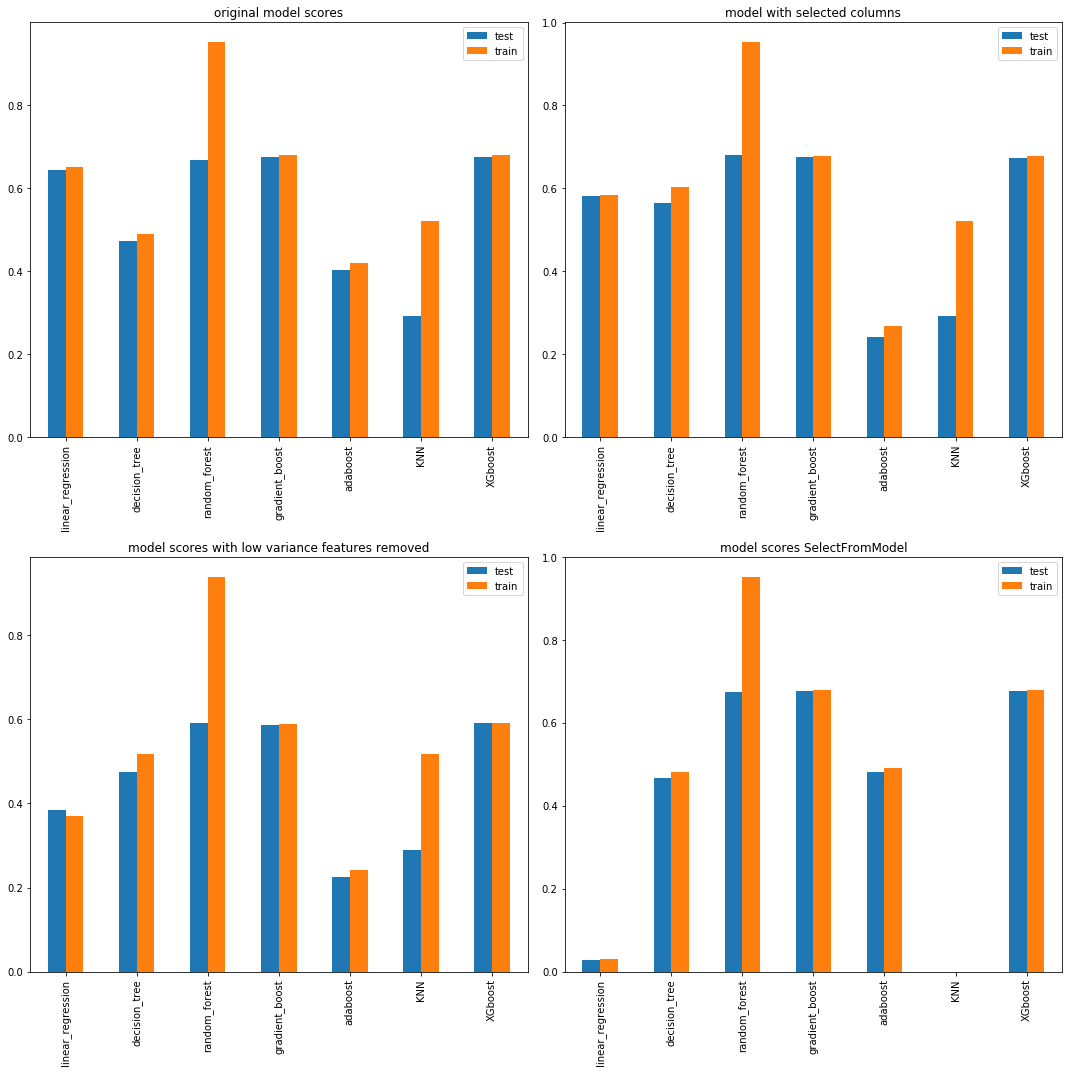

In [131]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
models.plot(kind='bar', ax=ax1)
ax1.set_title('original model scores')
models_less.plot(kind='bar', ax=ax2)
ax2.set_title('model with selected columns')
models_low_variance.plot(kind='bar', ax=ax3)
ax3.set_title('model scores with low variance features removed')
models_sfm.plot(kind='bar', ax=ax4)
ax4.set_title('model scores SelectFromModel')
plt.tight_layout()

*****

### Linear SVM regression

Taking too long!

In [118]:
#from sklearn.svm import SVR

#svr_linear = SVR(kernel='linear')

In [119]:
#svr_model = svr_linear.fit(X_train, y_train)

In [120]:
#svr_pred = svr_model.predict(X_test)